In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline

In [241]:
original_dataset = pd.read_csv('data/cancer_tpm_multiindexed.tsv', sep='\t', index_col=[0,1], header=[0,1])

In [242]:
# use only ENSG column IDs
original_dataset.columns = list(original_dataset.columns.get_level_values(0))

In [243]:
# Set output column as recurrence
output_col = original_dataset.index.get_level_values(1)

In [244]:
# Set index just to sample ID
original_dataset.index = list(original_dataset.index.get_level_values(0))

In [245]:
# Normalize the data????
norm = (original_dataset.loc['C1'] - original_dataset.loc['C1'].mean()).divide(original_dataset.loc['C1'].std())

In [246]:
# Add the output label
original_dataset['output'] = output_col

In [247]:
len(original_dataset[original_dataset.output == 1])

28

In [248]:
# Final dataset to do build the neural net.
original_dataset.head()

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000283101,ENSG00000283103,ENSG00000283108,ENSG00000283110,ENSG00000283117,ENSG00000283118,ENSG00000283122,ENSG00000283123,ENSG00000283125,output
C1,7.071605,13.279391,0.000000,6.212355,34.038592,9.231355,32.811263,19.136966,12.631348,11.220057,...,0.0,4.430132,0.000000,0.0,6.856902,16.599238,22.357146,0.0,19.542796,1
C2,60.610797,47.424080,0.000000,2.218590,35.828348,4.395669,22.498053,0.000000,5.413170,48.083612,...,0.0,0.000000,48.996429,0.0,9.795095,0.000000,4.562460,0.0,0.000000,1
C3,58.255903,60.455497,23.040206,12.120963,55.926653,8.005046,13.657227,14.935300,16.430065,14.594347,...,0.0,0.000000,14.871406,0.0,13.378542,0.000000,12.463189,0.0,0.000000,1
C4,29.917356,6.482332,8.646690,6.065120,10.494273,0.000000,23.064209,18.683413,9.865584,8.215603,...,0.0,0.000000,33.486271,0.0,13.388781,0.000000,6.236364,0.0,0.000000,1
C5,24.500322,53.675826,20.456404,16.142519,14.482668,0.000000,59.112604,8.840272,55.432674,0.000000,...,0.0,0.000000,26.407358,0.0,19.797049,57.509813,3.688509,0.0,45.138720,1


In [500]:
highest_750_expressed_genes = list(original_dataset.mean().sort_values(ascending=False).head(750).index)

# Model construction based heavily on: https://github.com/philipobrien/colab-notebooks/blob/master/Non_Linear_Data_Classification.ipynb

# Split into train and test datasets

In [505]:
preselected_ensgs = pd.read_csv('data/preselectedList', names=['ENSG'])
ensgs_subset = list(preselected_ensgs['ENSG'])

In [504]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
sns.set()

# This never changes...
MANUAL_SEED = 2
torch.manual_seed(MANUAL_SEED)

# Model methods definition 
class Model(nn.Module):
    def __init__(self, input_size, H1, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, H1)
        self.linear2 = nn.Linear(H1, output_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.linear(x))
        x = torch.sigmoid(self.linear2(x))
        return x
    
    def predict(self, x):
        pred = self.forward(x)
        return pred

# Split the datase for cross-validation purposes, 2/3 training, 1/3 testing
def split_dataset(original_dataset, fraction_test, random_seed, num_features=1000):
    train, test, train_labels, test_labels = train_test_split(original_dataset, 
                                                              output_col, 
                                                              stratify = output_col,
                                                              test_size=fraction_test,
                                                              random_state = SPLIT_SEED)
    
    print('Using only the first {} genes...'.format(num_features))
    X = np.array(train[train.columns[0:num_features]])

    y = np.array(train.output)

    # Tensorify the input and output arrays
    x_data = torch.FloatTensor(X)
    y_data = torch.FloatTensor(y.reshape(len(y), 1))
    return x_data, y_data

# Loss function information: 
# https://medium.com/udacity-pytorch-challengers/a-brief-overview-of-loss-functions-in-pytorch-c0ddb78068f7
def run_model(x_data, y_data, num_features, hidden_layer_size=4, learning_rate=0.0001, epochs=5000):
    model = Model(num_features, hidden_layer_size, 1)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    losses = []
    for i in range(epochs):
        # Make predictions based on current weights in model
        y_pred = model.forward(x_data)

        # Calculate new loss
        loss = criterion(y_pred, y_data)
        losses.append(loss.item())

        if i%10000==0:
            print(f"epoch: {i}, loss: {loss.item()}")

        # Calculate gradient and back-propagate to calculate the new weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Find probabilities on the test set
    X_test = np.array(test[test.columns[0:num_features]])
    test_tensor = torch.FloatTensor(X_test)

    probs = []
    for t in test_tensor:
        probs.append(model.predict(t))
    probs = list([float(t[0]) for t in probs])
    
    return losses, probs



# Run the model using just the first 750 genes as a baseline to compare the preselected 750 breast cancer-associated genes against

In [ ]:
split_dataset(original_dataset, fraction_test, split_seed, 750)

In [ ]:
from random import sample 

# Variables
hidden_layer_sizes = [4, 8]
learning_rate = 0.0001
epochs = 100000
fraction_test = 0.33
split_seeds = range(1,5)
num_genes = 750


all_losses = []
all_probs = []


for split_seed in split_seeds:
    for hidden_layer_size in hidden_layer_sizes:
        print('Next run: split seed: {}, hidden layer size: {}...'.format(split_seed, hidden_layer_size))
        num_features = num_genes
        x_data, y_data = split_dataset(original_dataset, fraction_test, split_seed, num_features)
        losses, probs = run_model(x_data, y_data, num_features, hidden_layer_size, learning_rate, epochs)
        all_losses.append(losses)
        all_probs.append(probs)
        

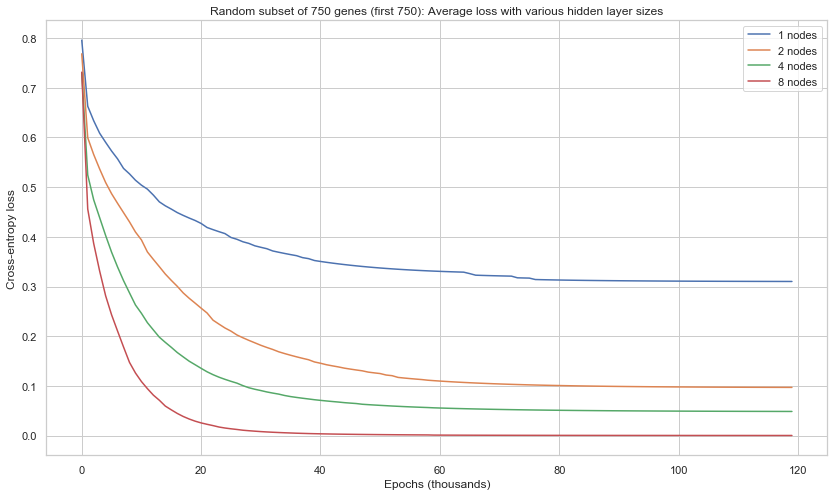

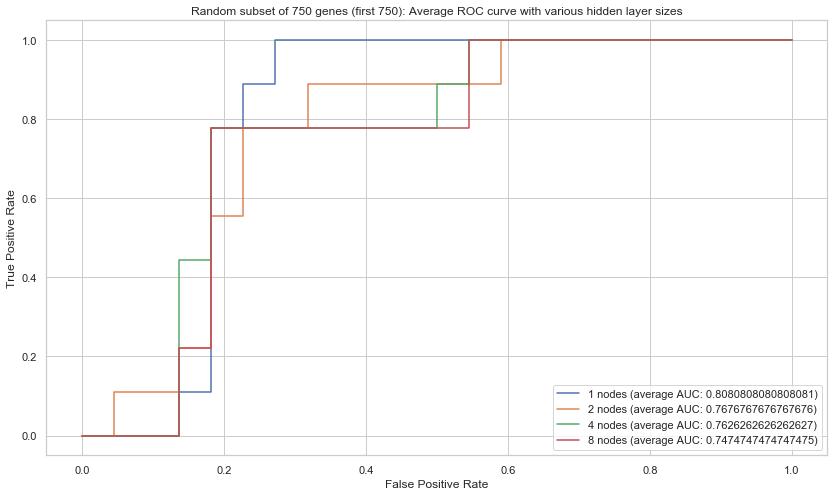

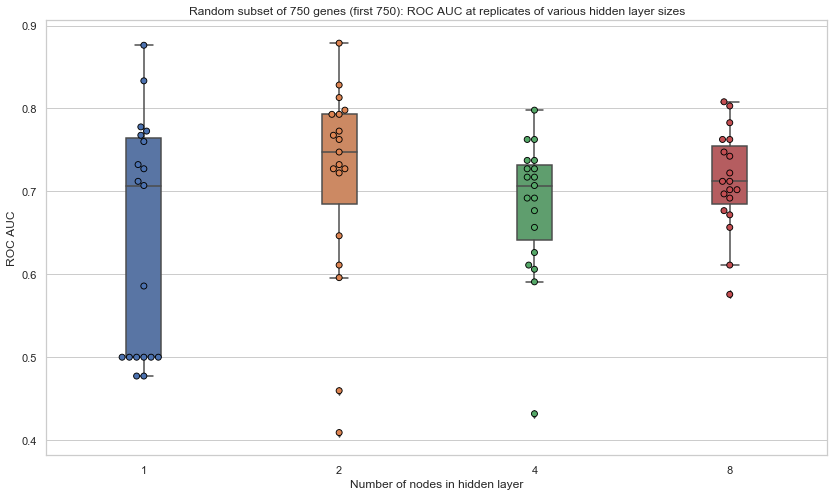

In [591]:
from collections import defaultdict


# Figure out average loss and average AUC for each layer size
i = 0

layer_to_losses = {}
layer_to_average_losses = {}
layer_to_indiv_probs = defaultdict(lambda:[])
layer_to_probs = {}
layer_to_average_probs = {}

for split_seed in split_seeds:
    for hidden_layer_size in hidden_layer_sizes:
        next_loss = all_losses[i]
        next_probs = all_probs[i]
        # thin out the losses by only keeping every 1000th entry
        thin_loss = [next_loss[j] for j,l in enumerate(next_loss) if j % 1000 == 0]
        thin_probs = next_probs
        
        # Keep running sum of the losses and probabilities at each epoch 
        if hidden_layer_size in layer_to_losses:
            addition = [thin_loss[j] + v for j,v in enumerate(layer_to_losses[hidden_layer_size])]
            layer_to_losses[hidden_layer_size] = addition
        else:
            layer_to_losses[hidden_layer_size] = thin_loss
            
        if hidden_layer_size in layer_to_probs:
            addition = [thin_probs[j] + v for j,v in enumerate(layer_to_probs[hidden_layer_size])]
            layer_to_probs[hidden_layer_size] = addition
        else:
            layer_to_probs[hidden_layer_size] = thin_probs
        
        layer_to_indiv_probs[hidden_layer_size].append(thin_probs)
            
        i = i + 1

# Now divide by the number of epochs to get the average of the loss/probs at each epoch for each hidden layer size
for hidden_layer_size, losses_per_size in layer_to_losses.items():
    layer_to_average_losses[hidden_layer_size] = [l/len(split_seeds) for l in losses_per_size]
    
for hidden_layer_size, probs_per_size in layer_to_probs.items():
    layer_to_average_probs[hidden_layer_size] = [l/len(split_seeds) for l in probs_per_size]

# Plot average losses with various hidden layer sizes
plt.figure(figsize=(14,8))
for k,v in layer_to_average_losses.items():
    plt.plot(v)
plt.legend(['{} nodes'.format(k) for k in layer_to_average_losses.keys()])
plt.title('Random subset of 750 genes (first 750): Average loss with various hidden layer sizes')
plt.xlabel('Epochs (thousands)')
plt.ylabel('Cross-entropy loss')


# Plot average ROC with various hidden layer sizes
plt.figure(figsize=(14,8))
for k,v in layer_to_average_probs.items():
    fpr, tpr, thresholds = roc_curve(test_labels, v, pos_label=1)
    plt.plot(fpr, tpr)

average_aucs = [roc_auc_score(test_labels, v) for k,v in layer_to_average_probs.items()]

plt.legend(['{} nodes (average AUC: {})'.format(k, average_aucs[i]) for i, k in enumerate(layer_to_average_losses.keys())])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random subset of 750 genes (first 750): Average ROC curve with various hidden layer sizes')


layer_to_roc_aucs = defaultdict(lambda:[])
for layer_size,v in layer_to_indiv_probs.items():
    for probability in v:
        auc = roc_auc_score(test_labels, probability)
        layer_to_roc_aucs[layer_size].append(auc)

        
import seaborn as sns, operator as op

plt.figure(figsize=(14,8))
# sort keys and values together
sorted_keys, sorted_vals = list(layer_to_roc_aucs.keys()), list(layer_to_roc_aucs.values())

# almost verbatim from question
sns.set(context='notebook', style='whitegrid')
sns.boxplot(data=sorted_vals, width=.18)
sns.swarmplot(data=sorted_vals, size=6, edgecolor="black", linewidth=.9)

# category labels
plt.xticks(plt.xticks()[0], sorted_keys)
plt.title('Random subset of 750 genes (first 750): ROC AUC at replicates of various hidden layer sizes')
plt.ylabel('ROC AUC')
plt.xlabel('Number of nodes in hidden layer')
plt.show()

(array([ 2.,  9.,  0.,  4.,  5.,  6., 24., 15.,  8.,  3.]),
 array([0.40909091, 0.45606061, 0.5030303 , 0.55      , 0.5969697 ,
        0.64393939, 0.69090909, 0.73787879, 0.78484848, 0.83181818,
        0.87878788]),
 <a list of 10 Patch objects>)

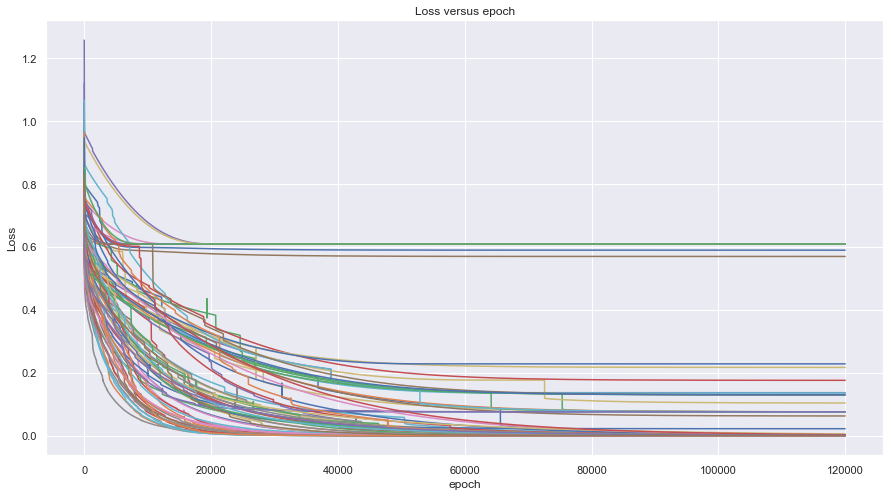

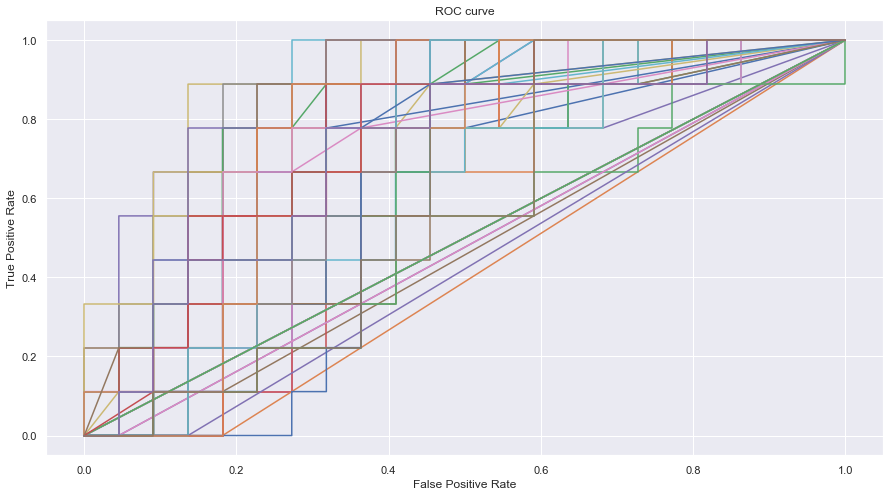

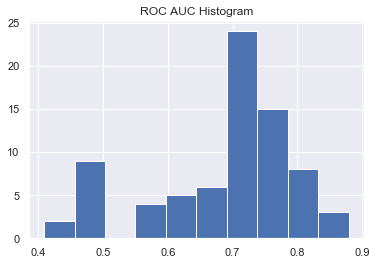

In [507]:
# Plot loss function as a function of training epoch
plt.figure(figsize=(15,8))
for loss in all_losses:
    plt.plot(range(epochs), loss)
    plt.title('Loss versus epoch')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    
# Plot ROC curve and calculate the area under the curve for the ROC curve
plt.figure(figsize=(15,8))
for probs in all_probs:
    fpr, tpr, thresholds = roc_curve(test_labels, probs, pos_label=1)
    #print('Thresholds: ', thresholds)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    
plt.figure()
roc_aucs = [roc_auc_score(test_labels, probs) for probs in all_probs]
plt.title('ROC AUC Histogram')
plt.hist(roc_aucs)

# Now do it with just the 750 pre-selected genes

In [601]:
print(len(ensgs_subset))
preselected_dataset = original_dataset[ensgs_subset+['output']]
len(preselected_dataset.columns)

750


751

In [ ]:
# Variables
hidden_layer_sizes = [2, 4, 8]
learning_rate = 0.0001
epochs = 100000
fraction_test = 0.33
split_seeds = range(1,4)
num_genes = len(ensgs_subset)


all_preselected_losses = []
all_preselected_probs = []


for split_seed in split_seeds:
    for hidden_layer_size in hidden_layer_sizes:
        print('Next run: split seed: {}, hidden layer size: {}...'.format(split_seed, hidden_layer_size))
        num_features = num_genes
        x_data, y_data = split_dataset(preselected_dataset, fraction_test, split_seed, num_features)
        losses, probs = run_model(x_data, y_data, num_features, hidden_layer_size, learning_rate, epochs)
        all_preselected_losses.append(losses)
        all_preselected_probs.append(probs)
        
        


Next run: split seed: 1, hidden layer size: 2...
Using only the first 750 genes...
epoch: 0, loss: 0.8780993819236755
epoch: 10000, loss: 0.4695184826850891
epoch: 20000, loss: 0.3313349783420563
epoch: 30000, loss: 0.23374685645103455
epoch: 40000, loss: 0.1686171591281891
epoch: 50000, loss: 0.12744051218032837
epoch: 60000, loss: 0.10276573896408081
epoch: 70000, loss: 0.08885639160871506
epoch: 80000, loss: 0.08155610412359238
epoch: 90000, loss: 0.07802221179008484
Next run: split seed: 1, hidden layer size: 4...
Using only the first 750 genes...
epoch: 0, loss: 0.8811780214309692
epoch: 10000, loss: 0.27319270372390747
epoch: 20000, loss: 0.13658207654953003
epoch: 30000, loss: 0.07627680897712708
epoch: 40000, loss: 0.045883115381002426
epoch: 50000, loss: 0.028615448623895645
epoch: 60000, loss: 0.018013181164860725
epoch: 70000, loss: 0.011327165178954601
epoch: 80000, loss: 0.007099352311342955
epoch: 90000, loss: 0.004436117596924305
Next run: split seed: 1, hidden layer siz

In [595]:
"""
pd.DataFrame([all_losses,
              all_probs,
              all_preselected_losses, 
              all_preselected_probs], index=['losses', 'probs', 'preselected_losses', 'preselected_probs'])\
.to_csv('losses_and_probs_first_two_steps.tsv', sep='\t', header=True)
"""

"\npd.DataFrame([all_losses,\n              all_probs,\n              all_preselected_losses, \n              all_preselected_probs], index=['losses', 'probs', 'preselected_losses', 'preselected_probs']).to_csv('losses_and_probs_first_two_steps.tsv', sep='\t', header=True)\n"

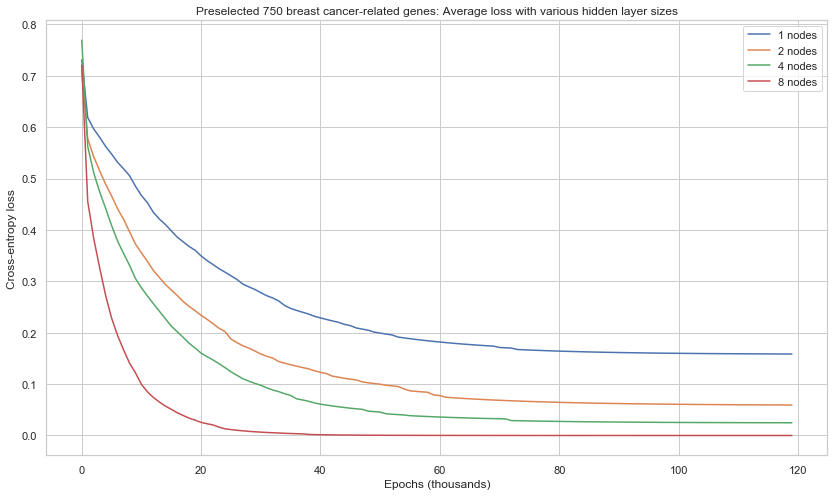

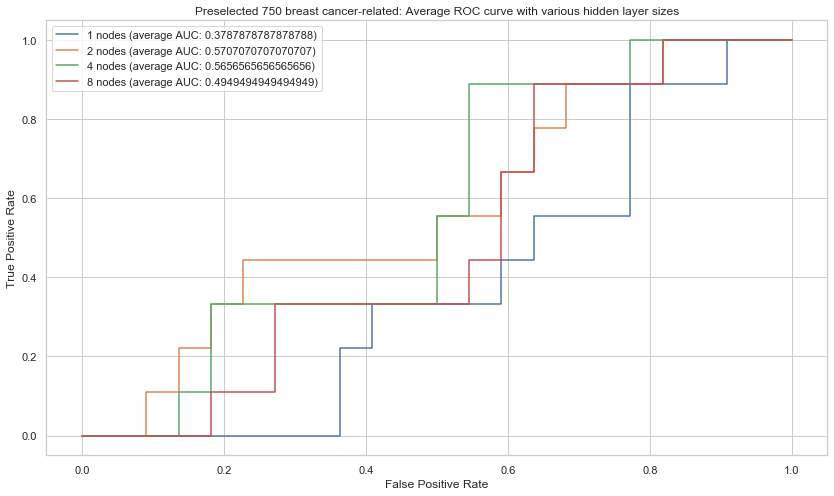

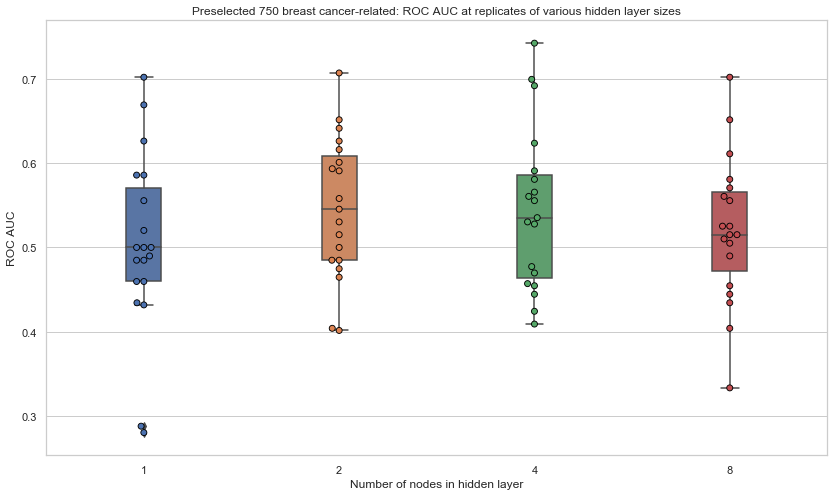

In [592]:
from collections import defaultdict


# Figure out average loss and average AUC for each layer size
i = 0

layer_to_losses = {}
layer_to_average_losses = {}
layer_to_indiv_probs = defaultdict(lambda:[])
layer_to_probs = {}
layer_to_average_probs = {}

for split_seed in split_seeds:
    for hidden_layer_size in hidden_layer_sizes:
        next_loss = all_preselected_losses[i]
        next_probs = all_preselected_probs[i]
        # thin out the losses by only keeping every 1000th entry
        thin_loss = [next_loss[j] for j,l in enumerate(next_loss) if j % 1000 == 0]
        thin_probs = next_probs
        
        # Keep running sum of the losses and probabilities at each epoch 
        if hidden_layer_size in layer_to_losses:
            addition = [thin_loss[j] + v for j,v in enumerate(layer_to_losses[hidden_layer_size])]
            layer_to_losses[hidden_layer_size] = addition
        else:
            layer_to_losses[hidden_layer_size] = thin_loss
            
        if hidden_layer_size in layer_to_probs:
            addition = [thin_probs[j] + v for j,v in enumerate(layer_to_probs[hidden_layer_size])]
            layer_to_probs[hidden_layer_size] = addition
        else:
            layer_to_probs[hidden_layer_size] = thin_probs
        
        layer_to_indiv_probs[hidden_layer_size].append(thin_probs)
            
        i = i + 1

# Now divide by the number of epochs to get the average of the loss/probs at each epoch for each hidden layer size
for hidden_layer_size, losses_per_size in layer_to_losses.items():
    layer_to_average_losses[hidden_layer_size] = [l/len(split_seeds) for l in losses_per_size]
    
for hidden_layer_size, probs_per_size in layer_to_probs.items():
    layer_to_average_probs[hidden_layer_size] = [l/len(split_seeds) for l in probs_per_size]

# Plot average losses with various hidden layer sizes
plt.figure(figsize=(14,8))
for k,v in layer_to_average_losses.items():
    plt.plot(v)
plt.legend(['{} nodes'.format(k) for k in layer_to_average_losses.keys()])
plt.title('Preselected 750 breast cancer-related genes: Average loss with various hidden layer sizes')
plt.xlabel('Epochs (thousands)')
plt.ylabel('Cross-entropy loss')


# Plot average ROC with various hidden layer sizes
plt.figure(figsize=(14,8))
for k,v in layer_to_average_probs.items():
    fpr, tpr, thresholds = roc_curve(test_labels, v, pos_label=1)
    plt.plot(fpr, tpr)

average_aucs = [roc_auc_score(test_labels, v) for k,v in layer_to_average_probs.items()]

plt.legend(['{} nodes (average AUC: {})'.format(k, average_aucs[i]) for i, k in enumerate(layer_to_average_losses.keys())])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Preselected 750 breast cancer-related: Average ROC curve with various hidden layer sizes')


layer_to_roc_aucs = defaultdict(lambda:[])
for layer_size,v in layer_to_indiv_probs.items():
    for probability in v:
        auc = roc_auc_score(test_labels, probability)
        layer_to_roc_aucs[layer_size].append(auc)

        
import seaborn as sns, operator as op

plt.figure(figsize=(14,8))
# sort keys and values together
sorted_keys, sorted_vals = list(layer_to_roc_aucs.keys()), list(layer_to_roc_aucs.values())

# almost verbatim from question
sns.set(context='notebook', style='whitegrid')
sns.boxplot(data=sorted_vals, width=.18)
sns.swarmplot(data=sorted_vals, size=6, edgecolor="black", linewidth=.9)

# category labels
plt.xticks(plt.xticks()[0], sorted_keys)
plt.title('Preselected 750 breast cancer-related: ROC AUC at replicates of various hidden layer sizes')
plt.ylabel('ROC AUC')
plt.xlabel('Number of nodes in hidden layer')
plt.show()

(array([ 2.,  1.,  4., 12., 15., 14., 13.,  6.,  4.,  5.]),
 array([0.28030303, 0.32651515, 0.37272727, 0.41893939, 0.46515152,
        0.51136364, 0.55757576, 0.60378788, 0.65      , 0.69621212,
        0.74242424]),
 <a list of 10 Patch objects>)

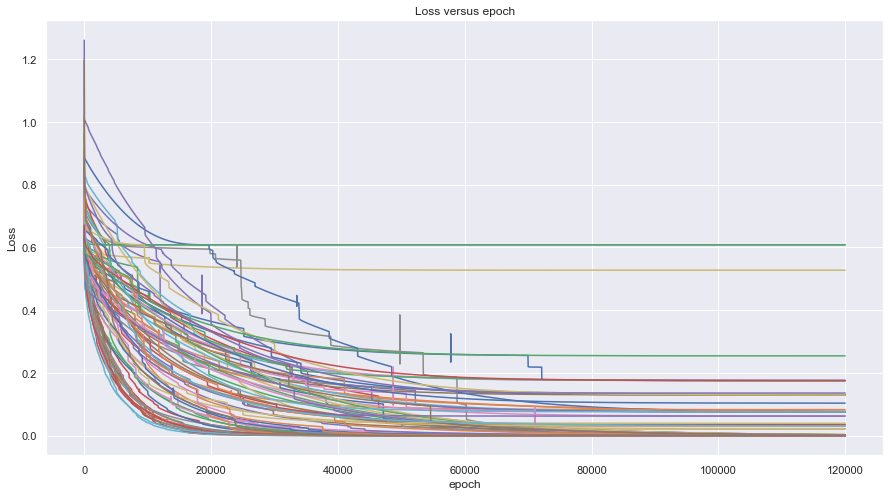

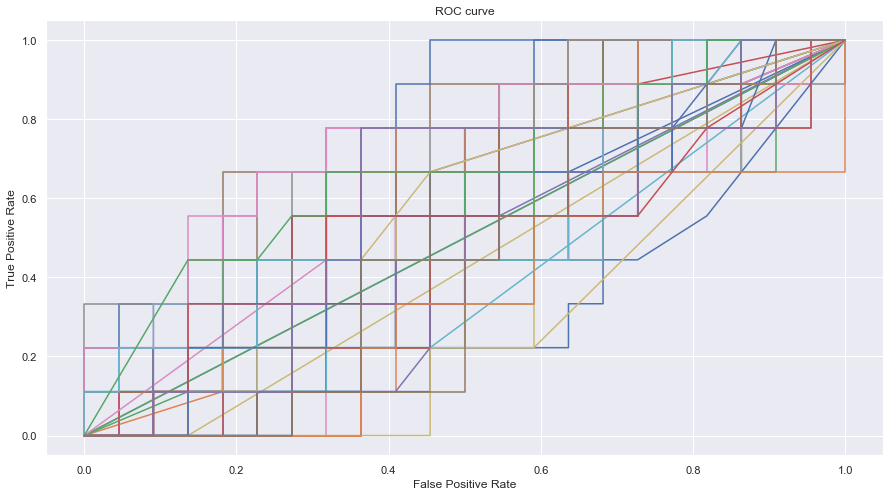

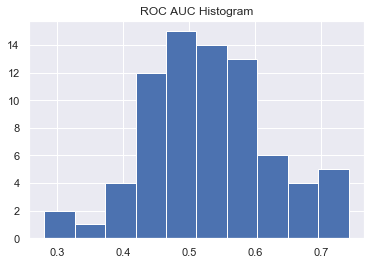

In [511]:
# Plot loss function as a function of training epoch
plt.figure(figsize=(15,8))
for loss in all_preselected_losses:
    plt.plot(range(epochs), loss)
    plt.title('Loss versus epoch')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    
# Plot ROC curve and calculate the area under the curve for the ROC curve
plt.figure(figsize=(15,8))
for probs in all_preselected_probs:
    fpr, tpr, thresholds = roc_curve(test_labels, probs, pos_label=1)
    #print('Thresholds: ', thresholds)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    
plt.figure()
roc_aucs = [roc_auc_score(test_labels, probs) for probs in all_preselected_probs]
plt.title('ROC AUC Histogram')
plt.hist(roc_aucs)

# And now use the 750 highest mean expression genes

In [524]:
# Variables
hidden_layer_sizes = [1, 2, 4, 8]
learning_rate = 0.0001
epochs = 120000
fraction_test = 0.33
split_seeds = range(1,20)
num_genes = len(ensgs_subset)


all_high_expression_losses = []
all_high_expression_probs = []


for split_seed in split_seeds:
    for hidden_layer_size in hidden_layer_sizes:
        print('Next run: split seed: {}, hidden layer size: {}...'.format(split_seed, hidden_layer_size))
        num_features = num_genes
        x_data, y_data = split_dataset(original_dataset[highest_750_expressed_genes+['output']], fraction_test, split_seed, num_features)
        losses, probs = run_model(x_data, y_data, num_features, hidden_layer_size, learning_rate, epochs)
        all_high_expression_losses.append(losses)
        all_high_expression_probs.append(probs)
        
        


Next run: split seed: 1, hidden layer size: 1...
Using only the first 750 genes...
epoch: 0, loss: 0.7210015654563904
epoch: 10000, loss: 0.5841367244720459
epoch: 20000, loss: 0.5841050148010254
epoch: 30000, loss: 0.5841050744056702
epoch: 40000, loss: 0.5841049551963806
epoch: 50000, loss: 0.5841050148010254
epoch: 60000, loss: 0.5296742916107178
epoch: 70000, loss: 0.5158959627151489
epoch: 80000, loss: 0.5096458792686462
epoch: 90000, loss: 0.5069832801818848
epoch: 100000, loss: 0.5058813691139221
epoch: 110000, loss: 0.5054328441619873
Next run: split seed: 1, hidden layer size: 2...
Using only the first 750 genes...
epoch: 0, loss: 1.0967804193496704
epoch: 10000, loss: 0.5792481899261475
epoch: 20000, loss: 0.53428053855896
epoch: 30000, loss: 0.5154733657836914
epoch: 40000, loss: 0.5136581063270569
epoch: 50000, loss: 0.5136581063270569
epoch: 60000, loss: 0.5136580467224121
epoch: 70000, loss: 0.5136580467224121
epoch: 80000, loss: 0.5136580467224121
epoch: 90000, loss: 0.5

epoch: 110000, loss: 0.5413057208061218
Next run: split seed: 4, hidden layer size: 8...
Using only the first 750 genes...
epoch: 0, loss: 0.7165565490722656
epoch: 10000, loss: 0.43277156352996826
epoch: 20000, loss: 0.33534640073776245
epoch: 30000, loss: 0.3039279580116272
epoch: 40000, loss: 0.2955358028411865
epoch: 50000, loss: 0.2953662574291229
epoch: 60000, loss: 0.28279292583465576
epoch: 70000, loss: 0.24758747220039368
epoch: 80000, loss: 0.18370139598846436
epoch: 90000, loss: 0.17486798763275146
epoch: 100000, loss: 0.21063241362571716
epoch: 110000, loss: 0.2104957401752472
Next run: split seed: 5, hidden layer size: 1...
Using only the first 750 genes...
epoch: 0, loss: 0.6168374419212341
epoch: 10000, loss: 0.5717594027519226
epoch: 20000, loss: 0.5717592835426331
epoch: 30000, loss: 0.5717592835426331
epoch: 40000, loss: 0.5717594027519226
epoch: 50000, loss: 0.5717593431472778
epoch: 60000, loss: 0.5717593431472778
epoch: 70000, loss: 0.5717594027519226
epoch: 80000,

epoch: 100000, loss: 0.5762563943862915
epoch: 110000, loss: 0.5762564539909363
Next run: split seed: 8, hidden layer size: 4...
Using only the first 750 genes...
epoch: 0, loss: 0.7642731666564941
epoch: 10000, loss: 0.5274155735969543
epoch: 20000, loss: 0.48328182101249695
epoch: 30000, loss: 0.4794662296772003
epoch: 40000, loss: 0.47861984372138977
epoch: 50000, loss: 0.47827085852622986
epoch: 60000, loss: 0.47812825441360474
epoch: 70000, loss: 0.4780704379081726
epoch: 80000, loss: 0.4780469238758087
epoch: 90000, loss: 0.4780375361442566
epoch: 100000, loss: 0.4780336618423462
epoch: 110000, loss: 0.4780321419239044
Next run: split seed: 8, hidden layer size: 8...
Using only the first 750 genes...
epoch: 0, loss: 0.8249503374099731
epoch: 10000, loss: 0.4691341519355774
epoch: 20000, loss: 0.37773260474205017
epoch: 30000, loss: 0.3468768298625946
epoch: 40000, loss: 0.32795652747154236
epoch: 50000, loss: 0.31560274958610535
epoch: 60000, loss: 0.30631664395332336
epoch: 7000

epoch: 90000, loss: 0.5965447425842285
epoch: 100000, loss: 0.5965448617935181
epoch: 110000, loss: 0.5965447425842285
Next run: split seed: 12, hidden layer size: 2...
Using only the first 750 genes...
epoch: 0, loss: 0.8230323791503906
epoch: 10000, loss: 0.5779249668121338
epoch: 20000, loss: 0.560698390007019
epoch: 30000, loss: 0.5582781434059143
epoch: 40000, loss: 0.5582782030105591
epoch: 50000, loss: 0.535588264465332
epoch: 60000, loss: 0.5355855822563171
epoch: 70000, loss: 0.5355855822563171
epoch: 80000, loss: 0.5355855822563171
epoch: 90000, loss: 0.5355855822563171
epoch: 100000, loss: 0.5355856418609619
epoch: 110000, loss: 0.5355855822563171
Next run: split seed: 12, hidden layer size: 4...
Using only the first 750 genes...
epoch: 0, loss: 0.7539010047912598
epoch: 10000, loss: 0.5790268182754517
epoch: 20000, loss: 0.5718064308166504
epoch: 30000, loss: 0.5679323077201843
epoch: 40000, loss: 0.5048041343688965
epoch: 50000, loss: 0.5016778111457825
epoch: 60000, loss:

epoch: 70000, loss: 0.18018236756324768
epoch: 80000, loss: 0.1797412484884262
epoch: 90000, loss: 0.17953254282474518
epoch: 100000, loss: 0.1794302612543106
epoch: 110000, loss: 0.17937809228897095
Next run: split seed: 16, hidden layer size: 1...
Using only the first 750 genes...
epoch: 0, loss: 0.7206394672393799
epoch: 10000, loss: 0.5418453216552734
epoch: 20000, loss: 0.541533350944519
epoch: 30000, loss: 0.5415334105491638
epoch: 40000, loss: 0.5337226390838623
epoch: 50000, loss: 0.5337226390838623
epoch: 60000, loss: 0.5337225794792175
epoch: 70000, loss: 0.5337226390838623
epoch: 80000, loss: 0.5337226390838623
epoch: 90000, loss: 0.5337226390838623
epoch: 100000, loss: 0.5337226390838623
epoch: 110000, loss: 0.5337225794792175
Next run: split seed: 16, hidden layer size: 2...
Using only the first 750 genes...
epoch: 0, loss: 0.649893581867218
epoch: 10000, loss: 0.5864061713218689
epoch: 20000, loss: 0.5802433490753174
epoch: 30000, loss: 0.5769076943397522
epoch: 40000, lo

epoch: 60000, loss: 0.4726194739341736
epoch: 70000, loss: 0.47249171137809753
epoch: 80000, loss: 0.4724399447441101
epoch: 90000, loss: 0.47241899371147156
epoch: 100000, loss: 0.47241055965423584
epoch: 110000, loss: 0.47240713238716125
Next run: split seed: 19, hidden layer size: 8...
Using only the first 750 genes...
epoch: 0, loss: 0.7292855381965637
epoch: 10000, loss: 0.4376707673072815
epoch: 20000, loss: 0.34474146366119385
epoch: 30000, loss: 0.3333972990512848
epoch: 40000, loss: 0.3009808659553528
epoch: 50000, loss: 0.26732969284057617
epoch: 60000, loss: 0.2598221004009247
epoch: 70000, loss: 0.2584659457206726
epoch: 80000, loss: 0.25760069489479065
epoch: 90000, loss: 0.2570332884788513
epoch: 100000, loss: 0.2566683888435364
epoch: 110000, loss: 0.2564358413219452


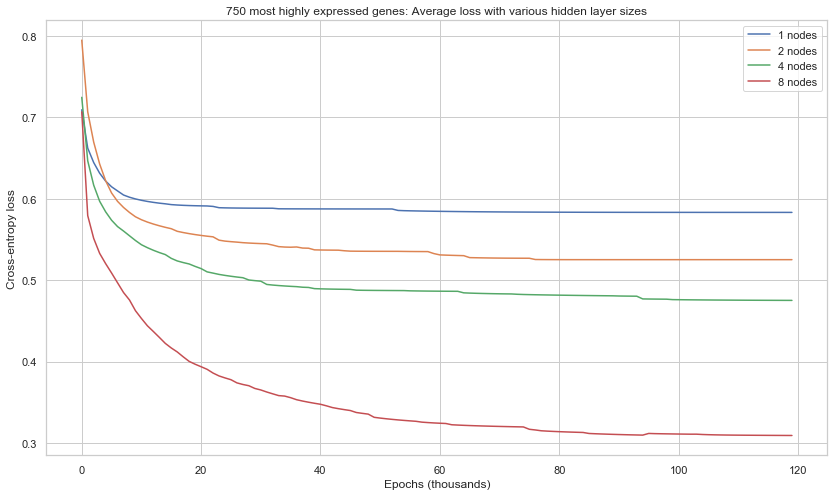

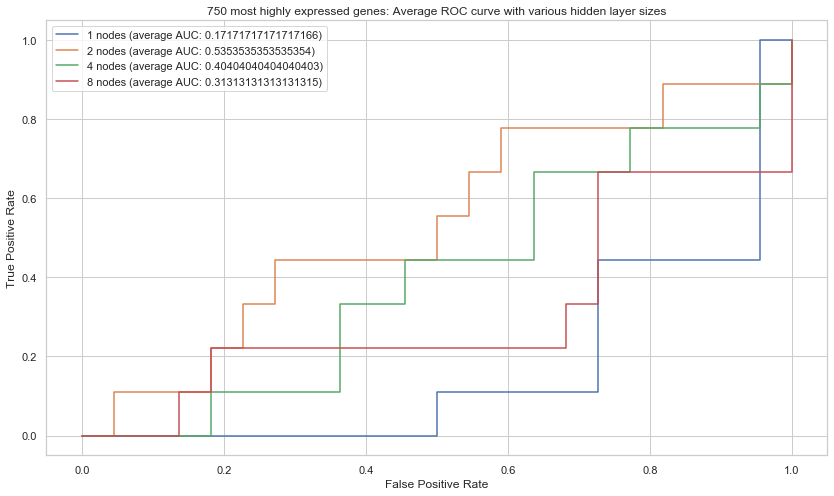

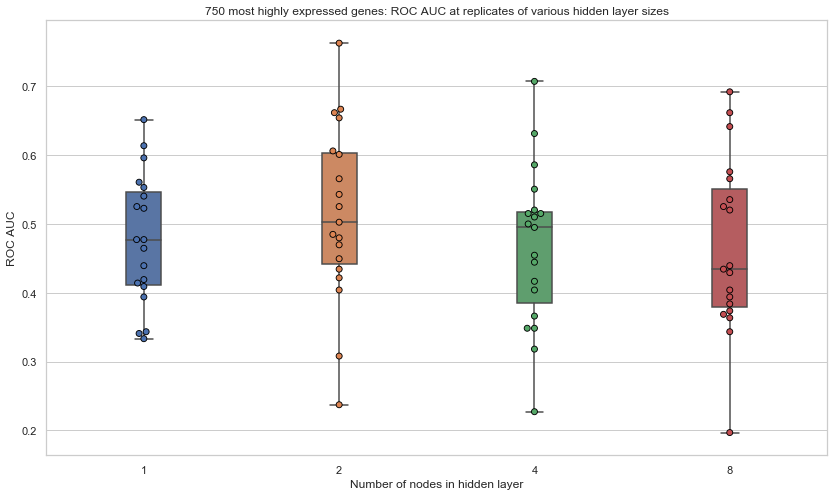

In [594]:
from collections import defaultdict


# Figure out average loss and average AUC for each layer size
i = 0

layer_to_losses = {}
layer_to_average_losses = {}
layer_to_indiv_probs = defaultdict(lambda:[])
layer_to_probs = {}
layer_to_average_probs = {}

for split_seed in split_seeds:
    for hidden_layer_size in hidden_layer_sizes:
        next_loss = all_high_expression_losses[i]
        next_probs = all_high_expression_probs[i]
        # thin out the losses by only keeping every 1000th entry
        thin_loss = [next_loss[j] for j,l in enumerate(next_loss) if j % 1000 == 0]
        thin_probs = next_probs
        
        # Keep running sum of the losses and probabilities at each epoch 
        if hidden_layer_size in layer_to_losses:
            addition = [thin_loss[j] + v for j,v in enumerate(layer_to_losses[hidden_layer_size])]
            layer_to_losses[hidden_layer_size] = addition
        else:
            layer_to_losses[hidden_layer_size] = thin_loss
            
        if hidden_layer_size in layer_to_probs:
            addition = [thin_probs[j] + v for j,v in enumerate(layer_to_probs[hidden_layer_size])]
            layer_to_probs[hidden_layer_size] = addition
        else:
            layer_to_probs[hidden_layer_size] = thin_probs
        
        layer_to_indiv_probs[hidden_layer_size].append(thin_probs)
            
        i = i + 1

# Now divide by the number of epochs to get the average of the loss/probs at each epoch for each hidden layer size
for hidden_layer_size, losses_per_size in layer_to_losses.items():
    layer_to_average_losses[hidden_layer_size] = [l/len(split_seeds) for l in losses_per_size]
    
for hidden_layer_size, probs_per_size in layer_to_probs.items():
    layer_to_average_probs[hidden_layer_size] = [l/len(split_seeds) for l in probs_per_size]

# Plot average losses with various hidden layer sizes
plt.figure(figsize=(14,8))
for k,v in layer_to_average_losses.items():
    plt.plot(v)
plt.legend(['{} nodes'.format(k) for k in layer_to_average_losses.keys()])
plt.title('750 most highly expressed genes: Average loss with various hidden layer sizes')
plt.xlabel('Epochs (thousands)')
plt.ylabel('Cross-entropy loss')


# Plot average ROC with various hidden layer sizes
plt.figure(figsize=(14,8))
for k,v in layer_to_average_probs.items():
    fpr, tpr, thresholds = roc_curve(test_labels, v, pos_label=1)
    plt.plot(fpr, tpr)

average_aucs = [roc_auc_score(test_labels, v) for k,v in layer_to_average_probs.items()]

plt.legend(['{} nodes (average AUC: {})'.format(k, average_aucs[i]) for i, k in enumerate(layer_to_average_losses.keys())])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('750 most highly expressed genes: Average ROC curve with various hidden layer sizes')


layer_to_roc_aucs = defaultdict(lambda:[])
for layer_size,v in layer_to_indiv_probs.items():
    for probability in v:
        auc = roc_auc_score(test_labels, probability)
        layer_to_roc_aucs[layer_size].append(auc)

        
import seaborn as sns, operator as op

plt.figure(figsize=(14,8))
# sort keys and values together
sorted_keys, sorted_vals = list(layer_to_roc_aucs.keys()), list(layer_to_roc_aucs.values())

# almost verbatim from question
sns.set(context='notebook', style='whitegrid')
sns.boxplot(data=sorted_vals, width=.18)
sns.swarmplot(data=sorted_vals, size=6, edgecolor="black", linewidth=.9)

# category labels
plt.xticks(plt.xticks()[0], sorted_keys)
plt.title('750 most highly expressed genes: ROC AUC at replicates of various hidden layer sizes')
plt.ylabel('ROC AUC')
plt.xlabel('Number of nodes in hidden layer')
plt.show()

(array([ 3.,  1.,  9., 13., 13., 14.,  9.,  6.,  6.,  2.]),
 array([0.1969697 , 0.25353535, 0.31010101, 0.36666667, 0.42323232,
        0.47979798, 0.53636364, 0.59292929, 0.64949495, 0.70606061,
        0.76262626]),
 <a list of 10 Patch objects>)

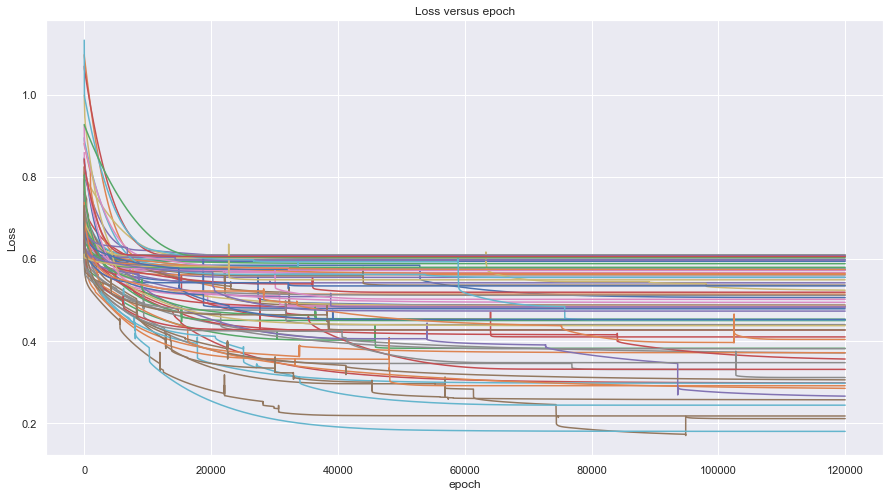

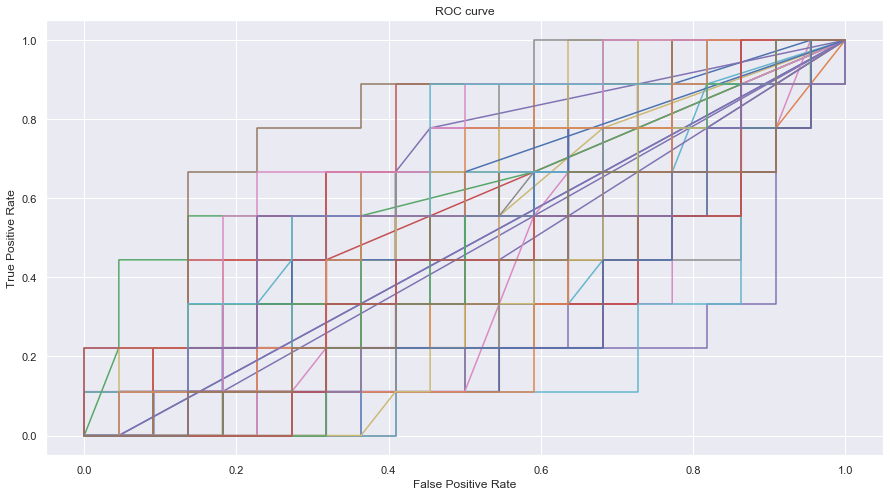

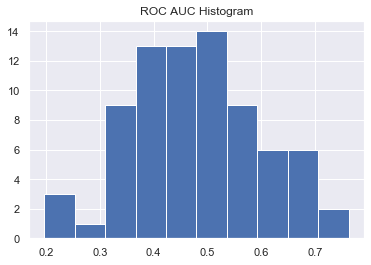

In [525]:
# Plot loss function as a function of training epoch
plt.figure(figsize=(15,8))
for loss in all_high_expression_losses:
    plt.plot(range(epochs), loss)
    plt.title('Loss versus epoch')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    
# Plot ROC curve and calculate the area under the curve for the ROC curve
plt.figure(figsize=(15,8))
for probs in all_high_expression_probs:
    fpr, tpr, thresholds = roc_curve(test_labels, probs, pos_label=1)
    #print('Thresholds: ', thresholds)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    
plt.figure()
roc_aucs = [roc_auc_score(test_labels, probs) for probs in all_high_expression_probs]
plt.title('ROC AUC Histogram')
plt.hist(roc_aucs)

In [596]:
"""
pd.DataFrame([all_losses,
              all_probs,
              all_preselected_losses, 
              all_preselected_probs,
              all_high_expression_losses,
              all_high_expression_probs
             ], index=['losses', 'probs', 'preselected_losses', 'preselected_probs', 'high_expression_losses', 'high_expression_probs'])\
.to_csv('losses_and_probs_first_three_steps.tsv', sep='\t', header=True)
"""

"\npd.DataFrame([all_losses,\n              all_probs,\n              all_preselected_losses, \n              all_preselected_probs,\n              all_high_expression_losses,\n              all_high_expression_probs\n             ], index=['losses', 'probs', 'preselected_losses', 'preselected_probs', 'high_expression_losses', 'high_expression_probs']).to_csv('losses_and_probs_first_three_steps.tsv', sep='\t', header=True)\n"